In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture 
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth
import itertools
from tqdm import tqdm


## Clustering of Merchants
### **Objective**: Perform a hard clustering on the merchants to obtain 3 to 5 clusters, which can be used for market segmentation.
### **Overview**: In this notebook, we aim to uncover some underlying cluster structure of our candidate merchant based on three engineered features (as listed below). These features are essential metrics for quantifying the business scale of a merchant, as we believe that not only the merchants with high volume of orders and customers but also small merchants should be given an opportunity to enlarge their business through availability of BNPL service for customers.
### **Attributes for clustering**:
   1. total_number_of_distinct_customers:
   2. monthly_average_number_of_orders:
   3. monthly_average_bnpl_revenue:
### **Clustering pipeline**:
 0. Preliminary Data Analysis
 1. Data Clustering
    1. K-means
    2. MeanShift
    3. DBSCAN
    4. Gaussian Mixture Model
 2. Clustering Evaluation
    1. Silhouette Coefficient
    2. Calinski-Harabasz Index
    3. Davies-Bouldin Index
 3. Clustering Model Deployment


In [2]:
merchant_df = pd.read_csv("../data/curated/agg_transaction_train.csv")
merchant_df = merchant_df[["merchant_abn",
                           "total_number_of_distinct_customers",
                           "monthly_average_number_of_orders",
                           "monthly_average_bnpl_revenue",
                           "take_rate"
                           ]]
merchant_df.head(5)

,merchant_abn,total_number_of_distinct_customers,monthly_average_number_of_orders,monthly_average_bnpl_revenue,take_rate
0,10023283211,2619,154.333333,33301.586223,0.1
1,10342410215,729,40.888889,15624.420327,6.3
2,10346855916,7,1.400000,2186.800497,3.5
3,10385163239,57,3.352941,1162.535621,6.6
4,10648956813,13062,1049.722222,67759.983409,6.6


### **PDA**
#### 1. The binary correlations between the three attributes are good, no multi-collinearity exists.
#### 2. As we can see that the distributions of the three attributes are very right-skewed, which can potentially lead to clusters that are too uneven in size. Therefore, log transformations will be beneficial to unskew the data.

In [7]:
features = [
            "monthly_average_bnpl_revenue",
            "monthly_average_number_of_orders",
            "total_number_of_distinct_customers"
            ]

X = merchant_df[features]

X.corr()


,monthly_average_bnpl_revenue,monthly_average_number_of_orders,total_number_of_distinct_customers
monthly_average_bnpl_revenue,1.000000,0.585222,0.673555
monthly_average_number_of_orders,0.585222,1.000000,0.740041
total_number_of_distinct_customers,0.673555,0.740041,1.000000


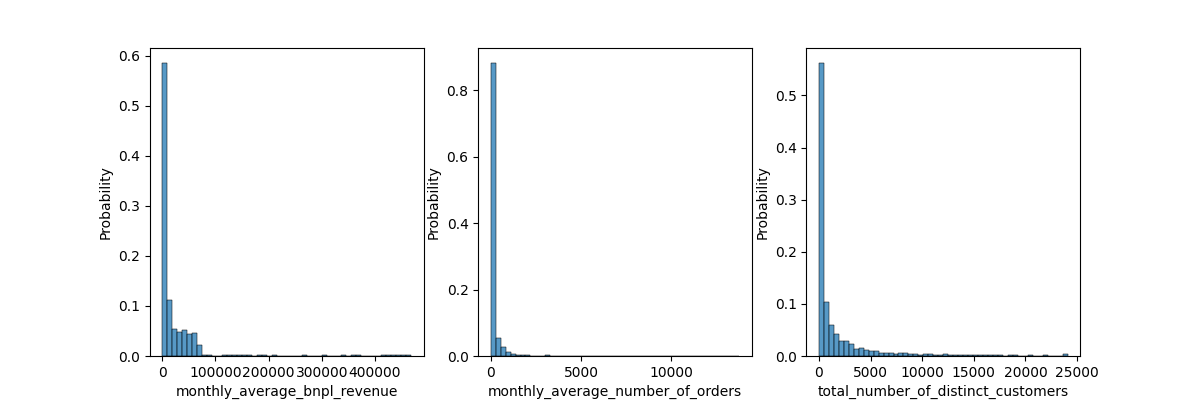

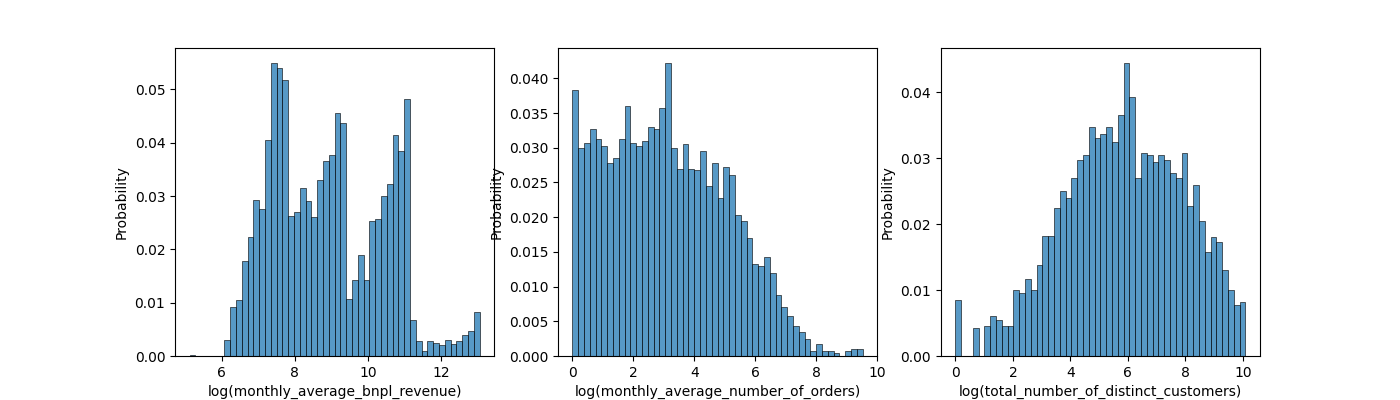

In [8]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4), dpi = 100)
for i in range(len(features)):
    sns.histplot(merchant_df[features[i]], 
                stat = 'probability', 
                bins=50,
                ax = ax[i])


# It seems that we can perform GMM on log(features)
fig, ax = plt.subplots(1, 3, figsize = (14, 4), dpi = 100)
for i in range(len(features)):
    sns.histplot(merchant_df[features[i]].apply(np.log), 
                stat = 'probability', 
                bins=50,
                ax = ax[i])
    ax[i].set_xlabel(f'log({ax[i].get_xlabel()})')

### **Clustering**

In [4]:
log_X = X.apply(np.log)

def homemade_GridSearch(model, parameters, data):
    """
    return a dataframe showing the gridsearch result
    parameters:
               model: a sklearn model
               parameters: a dictionary of parameters for the model, each parameter is a list of possible value
               data: the dataset to fit
    return:
           a dataframe which shows the performance of all combinations of parameters
    """
    # Name of the parameters
    parameter_names = list(parameters.keys())
    # Evaluation metrics
    eval_metrics = [silhouette_score, davies_bouldin_score, calinski_harabasz_score]
    # Name of the evaluation metrics
    eval_metric_names = ['silhouette_score', 'davies_bouldin_score', 'calinski_harabasz_score']

    # Store the performance in a dict
    performance_dict = {parameter: [] for parameter in parameter_names + eval_metric_names + ["num_clusters"]}

    for parameter_value in tqdm(itertools.product(*map(parameters.get, list(parameter_names)))):
        # Store the combination of parameters in a dict
        parameter_set = dict(zip(parameter_names, parameter_value))
        labels = model.set_params(**parameter_set).fit_predict(data)
        # Store the parameters and corresponding score
        for parameter_name in parameter_names:
            performance_dict[parameter_name].append(parameter_set[parameter_name])
        for eval_metric_name, eval_metric in zip(eval_metric_names, eval_metrics):
            try:
                score = eval_metric(data, labels)
            except:
                # If score cannot be calculated, return NaN
                score = np.nan
            performance_dict[eval_metric_name].append(score)
       
        # Add an additional column indicating the number of clusters
        performance_dict["num_clusters"].append(len(np.unique(labels)))

    return pd.DataFrame(performance_dict)
       


### K-Means

In [5]:
k_mean_params = {
    'n_clusters': [3, 4, 5],
    'random_state': [2022, ]
}

display(homemade_GridSearch(KMeans(), k_mean_params, X))
homemade_GridSearch(KMeans(), k_mean_params, log_X)

3it [00:01,  2.60it/s]


,n_clusters,random_state,silhouette_score,davies_bouldin_score,calinski_harabasz_score,num_clusters
0,3,2022,0.761312,0.385205,18567.865577,3
1,4,2022,0.765534,0.443601,24253.432252,4
2,5,2022,0.766876,0.441407,27401.552841,5


3it [00:01,  2.52it/s]


,n_clusters,random_state,silhouette_score,davies_bouldin_score,calinski_harabasz_score,num_clusters
0,3,2022,0.445766,0.762284,7097.404682,3
1,4,2022,0.392220,0.815187,6800.902669,4
2,5,2022,0.363841,0.858262,6479.385385,5


### MeanShift

In [6]:
mean_shift_params1 = {
     'bandwidth': [estimate_bandwidth(X, quantile=q) for q in np.linspace(0.00099, 0.9999, num=10)]
     }

mean_shift_params2 = {
     'bandwidth': [estimate_bandwidth(log_X, quantile=q) for q in np.linspace(0.00099, 0.9999, num=10)]
     }

display(homemade_GridSearch(MeanShift(), mean_shift_params1, X).query("num_clusters <= 5 & num_clusters >= 3"))
homemade_GridSearch(MeanShift(), mean_shift_params2, log_X).query("num_clusters <= 5 & num_clusters >= 3")

10it [02:28, 14.89s/it]


,bandwidth,silhouette_score,davies_bouldin_score,calinski_harabasz_score,num_clusters
8,57098.608172,0.858346,0.471246,8039.235964,4


10it [04:55, 29.51s/it]


,bandwidth,silhouette_score,davies_bouldin_score,calinski_harabasz_score,num_clusters
1,1.324227,0.337828,0.679304,3789.145522,4
2,1.984250,0.409236,0.658915,4058.079728,3


### DBSCAN

In [7]:
dbscan_params1 = {
    'eps': [10, 100, 1000, 5000, 10000, 50000, 100000],
    'min_samples': [1, 5, 10, 20, 50, 100, 500, 1000]
}
dbscan_params2 = {
    'eps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples': [1, 5, 10, 20, 50, 100, 500, 1000]
}

display(homemade_GridSearch(DBSCAN(), dbscan_params1, X).query("num_clusters <= 5 & num_clusters >= 3"))
homemade_GridSearch(DBSCAN(), dbscan_params2, log_X).query("num_clusters <= 5 & num_clusters >= 3")

56it [00:14,  3.78it/s]


,eps,min_samples,silhouette_score,davies_bouldin_score,calinski_harabasz_score,num_clusters
12,100,50,-0.282307,1.083445,117.496428,3
18,1000,10,0.456144,1.699441,556.854010,5
25,5000,5,0.599186,0.730955,2496.830740,5
34,10000,10,0.764814,0.488188,6887.702632,3


80it [00:14,  5.70it/s]


,eps,min_samples,silhouette_score,davies_bouldin_score,calinski_harabasz_score,num_clusters


### Gaussian Mixture Model

In [8]:
gmm_params = {
    'n_components': [3, 4, 5],
    'init_params': ['kmeans', 'random'],
    'random_state': [2022, ]
}

display(homemade_GridSearch(GaussianMixture(), gmm_params, X))
homemade_GridSearch(GaussianMixture(), gmm_params, log_X)

6it [00:02,  2.94it/s]


,n_components,init_params,random_state,silhouette_score,davies_bouldin_score,calinski_harabasz_score,num_clusters
0,3,kmeans,2022,0.422826,1.235851,1211.715359,3
1,3,random,2022,0.423437,1.234811,1214.672460,3
2,4,kmeans,2022,0.312955,1.510188,1608.922656,4
3,4,random,2022,0.341805,1.467036,1931.012657,4
4,5,kmeans,2022,0.027453,1.594557,807.791010,5
5,5,random,2022,0.027453,1.594557,807.791010,5


6it [00:01,  3.82it/s]


,n_components,init_params,random_state,silhouette_score,davies_bouldin_score,calinski_harabasz_score,num_clusters
0,3,kmeans,2022,0.353276,0.751545,4919.697890,3
1,3,random,2022,0.217759,3.274140,315.872019,3
2,4,kmeans,2022,0.322762,0.849071,5315.917842,4
3,4,random,2022,0.246363,1.372564,2361.478352,4
4,5,kmeans,2022,0.246093,0.896902,4108.184446,5
5,5,random,2022,0.225632,4.039352,1288.455804,5


### Cluster Visualization

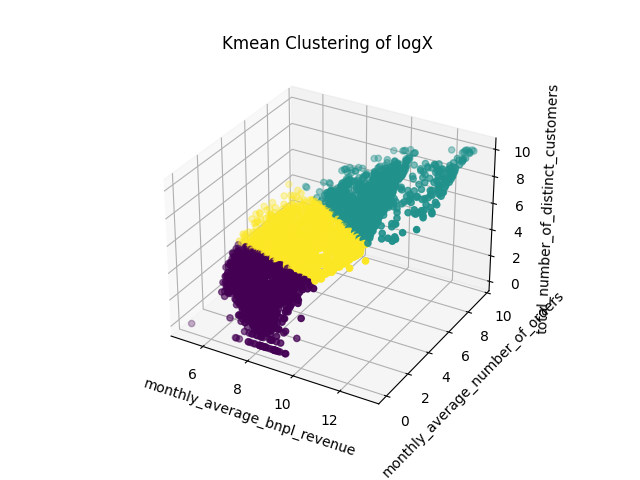

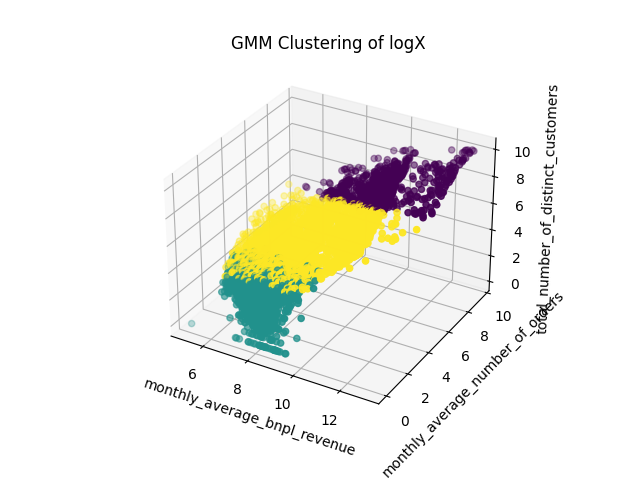

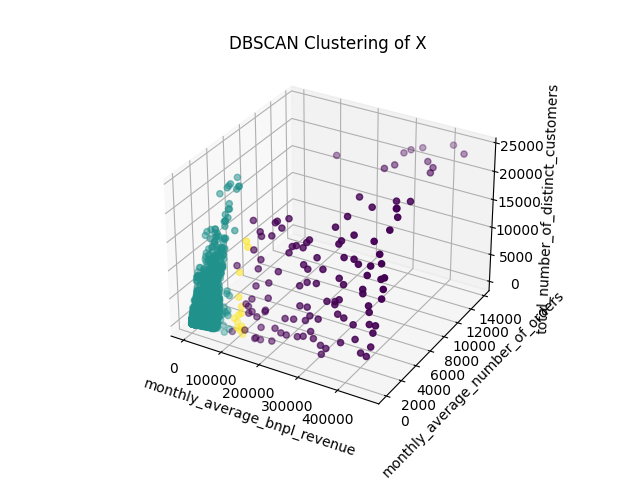

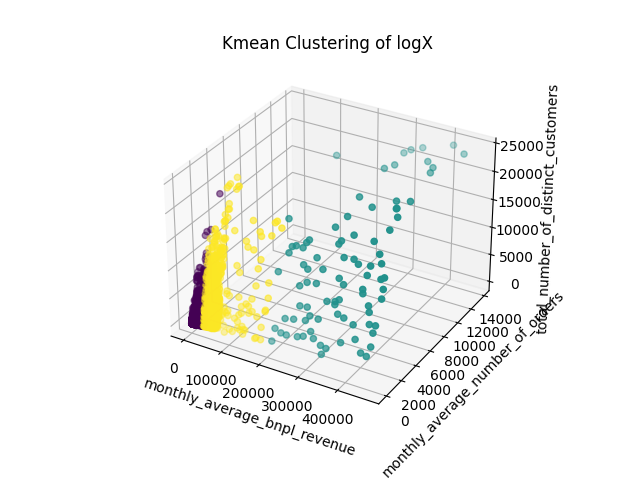

In [10]:
%matplotlib ipympl

def visualize_cluster(model, data, figname):
    """
    return a figure of clusters
    """
    data_copy = data.copy()

    # Define X, Y and Z axes
    xs = data_copy[features[0]]
    ys = data_copy[features[1]]
    zs = data_copy[features[2]]
    
    # Clusters of the data
    data_copy["cluster"] = model.fit_predict(data_copy)

    # Create a figure
    figure = plt.figure(dpi = 100)
    ax = figure.add_subplot(projection='3d')
    ax.scatter(xs, ys, zs, c=data_copy["cluster"])

    ax.set_title(figname)
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    ax.set_zlabel(features[2])
    
    return figure

fg1 = visualize_cluster(KMeans(n_clusters=3), log_X, "Kmean Clustering of logX")
fg2 = visualize_cluster(GaussianMixture(n_components=3, init_params='kmeans'), log_X, "GMM Clustering of logX")
fg3 = visualize_cluster(DBSCAN(eps=10000, min_samples=10), X, "DBSCAN Clustering of X")
fg4 = visualize_cluster(MeanShift(bandwidth=1.984250), log_X, "MeanShift Clustering of logX")

In [10]:
# Final clustering model
gmm = GaussianMixture(n_components=3, init_params='kmeans').fit(X)
merchant_df["label"] = gmm.predict(X)

# Predict the cluster of the unknown merchants 
pred = pd.read_csv("../data/curated/agg_transaction_pred.csv")
pred["label"] = gmm.predict(pred[features].apply(np.log))
pd.concat([merchant_df[["merchant_abn", "label"]], pred[["merchant_abn", "label"]]]) \
  .to_csv("../data/curated/merchant_clusters.csv", index=False)


# Fill missing take rate with cluster mean
merchant_df.groupby("label", as_index=False)["take_rate"].mean().to_csv("../data/curated/take_rate.csv", index=False)